# House Prices
### Advanced Regression Techniques

#### W207 Final Project
#### Teddy Fong, Ross MacLean, Alex West


We are working on the Kaggle competition involving housing data:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

This competition uses the Ames Housing Dataset compiled by Dean De Cock.

## Import Libraries and Configure Notebook

In [1]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing and stats libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats

# SK-learn libraries for regression
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
# import xgboost as xgb

# Other libraries
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

# create training and test dataframes
train = pd.read_csv('./Data/train.csv', index_col=0)
test = pd.read_csv('./Data/test.csv', index_col=0)

# create buckets from quantitative and qualitative variables
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

# Exploratory Data Analysis

## Examining the Dataset

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Not Normal

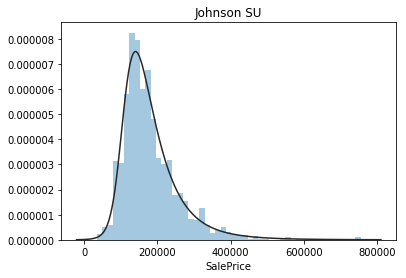

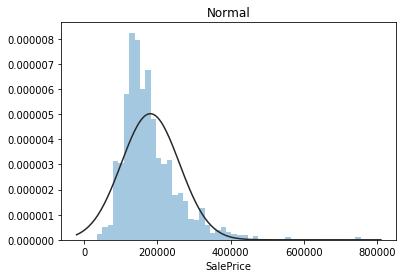

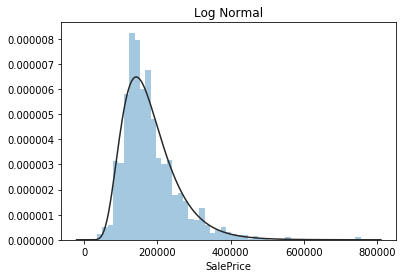

In [4]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

- Deviates from the normal distribution.
- appreciable positive skewness.
- Shows peakedness.

The target variable should probably be transformed

## Transforming into Normal Distribution

In [ ]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


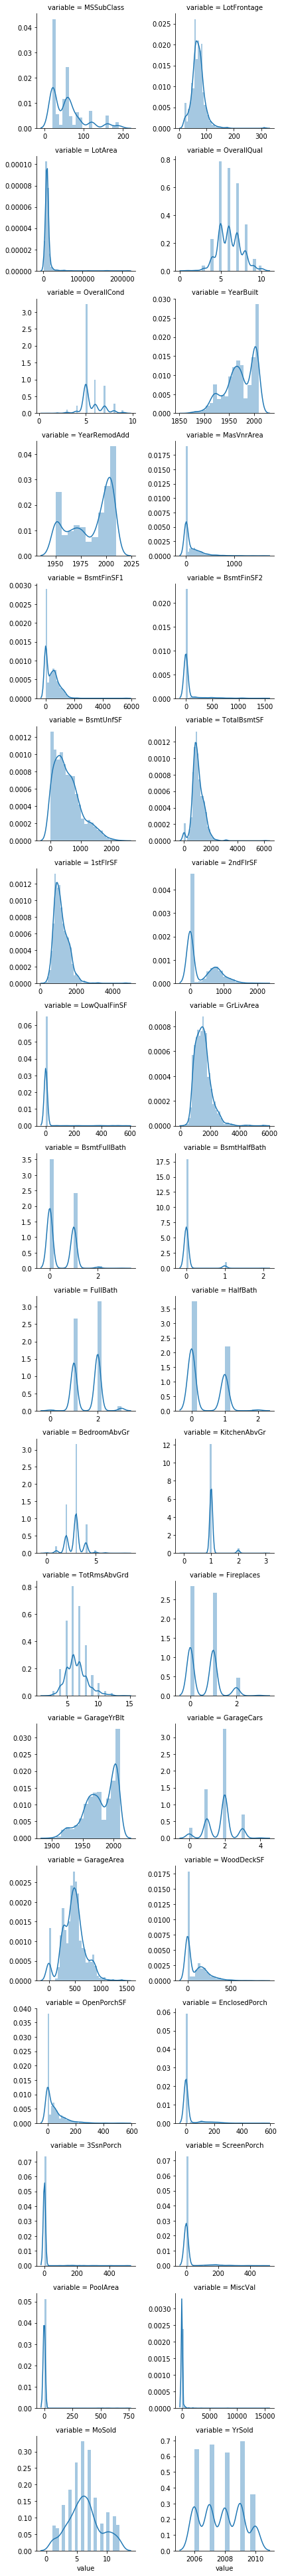

In [ ]:
# look at quantitative variables for deviations from normality
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.

## Categorical Variables
With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

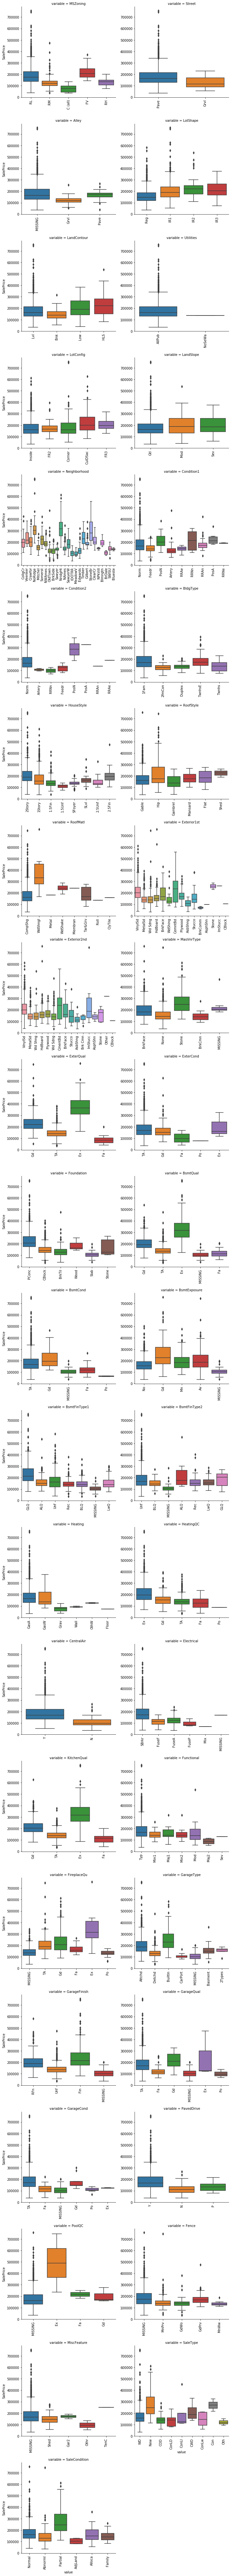

In [ ]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

Some categories seem to be more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

## Checking variabilities

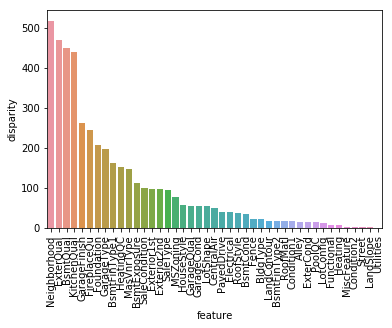

In [ ]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.



## Encoding Qualitative Features

In [ ]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


## Spearman Correlations

Generally to reduce confounding only variables uncorrelated with each other should be added to regression models (which are correlated with SalePrice).


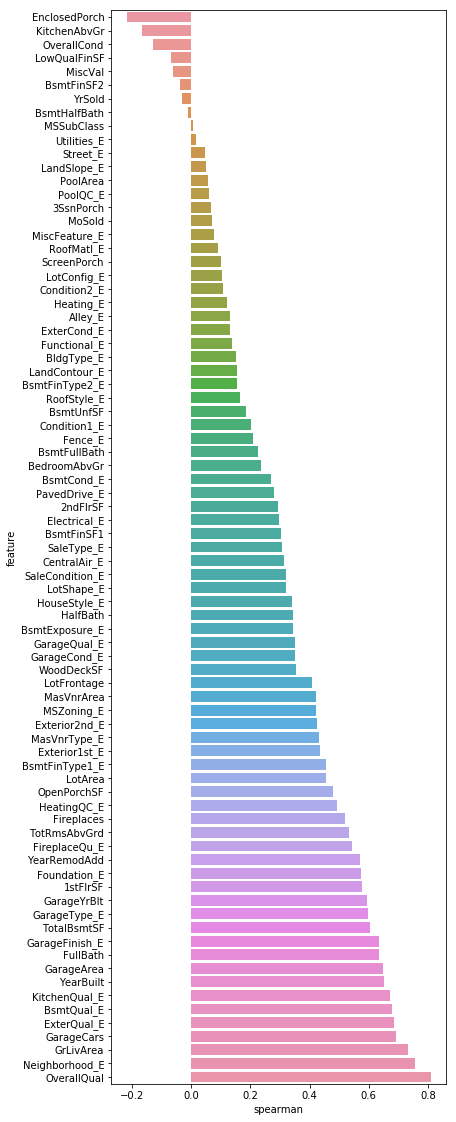

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.



## Heat maps

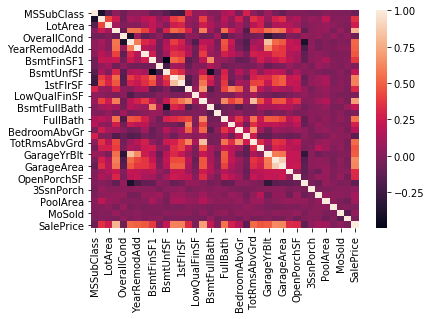

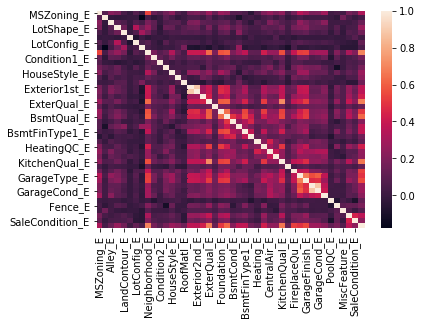

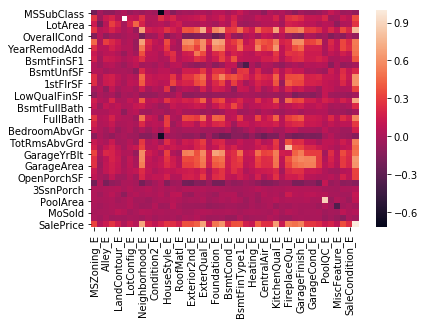

In [ ]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

There are many strong correlations between variables. Garages seem to be built same year as houses, basements have generally same area as first floor which is pretty obvious. Garage area is strongly correlated with number of cars. Neighborhood is correlated with lots of other variables and this confirms the idea that houses in same region share same characteristics. Dwelling type is negatively correlated with kitchen above grade square feet.


## Pair plots 
Comparing sale price to each independent variable

In [ ]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "SalePrice")

## Price Segments
It is possible that correlations shift with change of SalePrice.

In [ ]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

# Model Building 

## Log-Transform variables

In [ ]:
# error function for calculating score for Kaggle competition
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


# features = quantitative + qual_encoded + boolean + qdr
# lasso = linear_model.LassoLarsCV(max_iter=10000)
# X = train[features].fillna(0.).values
# Y = train['SalePrice'].values
# lasso.fit(X, np.log(Y))

# Ypred = np.exp(lasso.predict(X))
# error(Y, Ypred)

## Missing Values

In [ ]:
def plot_missing(train=train):
    
    # Calculate missing value counts
    missing = train.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(train.index) * 100

    # Plot missing counts
    fig, ax = plt.subplots(figsize = (7,4))
    plt.bar(missing.index, missing['percent_missing'])
    plt.ylabel('Percentage missing (%)')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
plot_missing(train=train)

In [ ]:
def return_variable_types(train=train):

    # Group variables by type
    qualitative = [var for var in train.columns[train.dtypes=='category']]
    quantitative = [var for var in train.columns[train.dtypes!='category']]
    
    return qualitative, quantitative

## Combine Datasets and Replace NaNs

In [ ]:
def create_full_dataset(train=train, test=test):

    # Create full data without SalePrice
    full_data = pd.concat((train.loc[:, train.columns != 'SalePrice'], test)).reset_index(drop=True)

    # Group variables by type
    qualitative, quantitative = return_variable_types(train=train)

    # Identify missing values
    missing = train.columns[train.isnull().any()]

    # Replace with appropriate value according to type
    for col in missing:
        if col in qualitative:
            full_data[col] = full_data[col].fillna('None')
        elif col in quantitative:
            full_data[col] = full_data[col].fillna(0)      
    return full_data

full_data = create_full_dataset(train=train, test=test)

## Label Encoding

In [ ]:
def label_encoder(full_data, columns):
    '''Label encode specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a label encoded data frame.'''

    # Label encode all qualitative variables
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(full_data[col].values)) 
        full_data[col] = label_encoder.transform(list(full_data[col].values))
    return full_data

# Label encoded train data shape
qualitative = return_variable_types(train=train)[0]
print('Label encoded:', label_encoder(full_data, qualitative).shape)

## One Hot Encoding

In [ ]:
def one_hot_encoder(full_data, columns):
    '''One hot encodes specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a one hot encoded data frame.'''
    
    # One hot encode all qualitative variables
    for col in columns:
        dummies = pd.get_dummies(full_data[col], prefix=col, sparse=False, drop_first=False)
        full_data = pd.concat([full_data, dummies], axis=1)
    return full_data

# One hot encoded train data shape
qualitative = return_variable_types(train=train)[0]
print('One hot encoded:', one_hot_encoder(full_data, qualitative).shape)

## Encode and Split Data

In [ ]:
def split_full_dataset(full_data, train=train):
    
    # Cut point for train/test post feature engineering
    cut = train.shape[0]
    
    # Recreate train and test sets
    train_data = full_data[:cut]
    y_label = list(train.loc[:, 'SalePrice'])
    train_data.loc[:, 'SalePrice'] = y_label
    test_data = full_data[cut:]

    # Random splits for train and dev sets
    train_set = train_data.sample(frac=0.8, random_state=0)
    dev_set = train_data.drop(train_set.index)

    # Select specified features for each dataset
    train_data, train_labels = train_set.loc[:, train_set.columns != 'SalePrice'], train_set.loc[:, 'SalePrice']
    dev_data, dev_labels = dev_set.loc[:, dev_set.columns != 'SalePrice'], dev_set.loc[:, 'SalePrice']
    
    return train_data, train_labels, dev_data, dev_labels, test_data

In [ ]:
def encode_and_split(dataset, encoder='None'):
    
    # Encode full dataset according to input parameter and split
    # into train, dev, test components for modeling.
    
    # Group variables by type    
    qualitative, quantitative = return_variable_types(train=train)
    
    if encoder == 'label_encoder':
        dataset_encoded = label_encoder(dataset, qualitative)
        train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(dataset_encoded, train=train)
    elif encoder == 'onehot_encoder':
        dataset_encoded = one_hot_encoder(dataset, qualitative)
        train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(dataset_encoded, train=train)
    else:
        train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(dataset, train=train)
        
    return train_data, train_labels, dev_data, dev_labels, test_data

In [ ]:
def print_dataset_shapes(full_data=full_data, train=train):
    # Display shape of datasets
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    print('train_data:', train_data.shape)
    print('dev_data:', dev_data.shape)
    print('test_data:', test_data.shape)
    
print_dataset_shapes()

In [ ]:
def root_mean_squared_error(y_value, y_predict):
    # Root mean square error
    rmse = np.sqrt(mean_squared_error(y_value, y_predict))
    print('RMSE: {:.4}'.format(rmse))

## Basic Linear Regression

In [ ]:
def linear_regression(dataset, encoder='None'):
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = encode_and_split(dataset, encoder=encoder)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(train_data, train_labels_log)
    predict_dev_log = lr.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Plot predicted vs. actual values
    fig, ax = plt.subplots(figsize = (6,4))

    #plt.scatter(dev_labels_log, predict_dev_log)
    plt.scatter(dev_labels, predict_dev_value)

    ax.set_title('Linear regression: Actual vs. Predicted')
    ax.set_xlabel('Actual price')
    ax.set_ylabel('Predicted price')

    # R^2 and root mean squared error
    print('Accuracy: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))
    root_mean_squared_error(dev_labels_log, predict_dev_log)

In [ ]:
print('Linear regression with label encoding')
linear_regression(full_data, encoder='label_encoder')

In [ ]:
print('Linear regression with one hot encoding')
linear_regression(full_data, encoder='onehot_encoder')

# Decision Tree Regression

In [ ]:
def decision_tree(dataset, encoder='None'):
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = encode_and_split(dataset, encoder=encoder)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    dt = DecisionTreeRegressor()
    dt.fit(train_data, train_labels_log)
    predict_dev_log = dt.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Plot predicted vs. actual values
    fig, ax = plt.subplots(figsize = (6,4))

    #plt.scatter(dev_labels_log, predict_dev_log)
    plt.scatter(dev_labels, predict_dev_value)

    ax.set_title('Decision Tree regression: Actual vs. Predicted')
    ax.set_xlabel('Actual price')
    ax.set_ylabel('Predicted price')

    # R^2 and root mean squared error
    print('Accuracy: {:.4f}'.format(dt.score(dev_data, dev_labels_log)))
    root_mean_squared_error(dev_labels_log, predict_dev_log)
    
decision_tree(full_data, encoder=label_encoder)

We note that we may be overfitting with so many leaves. Therefore, we try to limit the number of leaves to 20 and change the criterion to Max absolute error.

In [ ]:
def decision_tree(dataset, encoder='None'):
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = encode_and_split(dataset, encoder=encoder)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    dt = DecisionTreeRegressor(random_state = 0, max_leaf_nodes=20, criterion='mae', max_depth=10) 
    dt.fit(train_data, train_labels_log)
    predict_dev_log = dt.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Plot predicted vs. actual values
    fig, ax = plt.subplots(figsize = (6,4))

    #plt.scatter(dev_labels_log, predict_dev_log)
    plt.scatter(dev_labels, predict_dev_value)

    ax.set_title('Decision Tree regression: Actual vs. Predicted')
    ax.set_xlabel('Actual price')
    ax.set_ylabel('Predicted price')

    # R^2 and root mean squared error
    print('Accuracy: {:.4f}'.format(dt.score(dev_data, dev_labels_log)))
    root_mean_squared_error(dev_labels_log, predict_dev_log)
    
    # Top 15 features for information gain
    importances = dt.feature_importances_
    std = np.std(dt.feature_importances_,axis=0)
    indices = np.argsort(importances)[::-1]

    # Top 15 features for decision tree regressor
    print("\nTop 15 features for information gain in decision tree splits")
    for f in range(15):
        print('%d. Feature %d (%f)' % (f+1, indices[f], importances[indices[f]]))
        
    # This function applies the fitted decisiontree regressor to the dev data to determine what
    # leaf they belong to and assigns it to the array 'dev_leaf'
    dev_leaf = dt.apply(dev_data)

    # we assign the dev leaves to the dev data, which is saved as 'dev_array'
    dev_array = np.column_stack((dev_data, dev_leaf, dev_labels))
    
    # We then make the dev_array into a dataframe so we can group them to display the expected home price by leaf
    dev_df = pd.DataFrame(dev_array, index=range(dev_array.shape[0]), columns=range(dev_array.shape[1]))
    print("\nThis is the actual average home price by leaf data")
    print(dev_df.groupby([len(dev_df.columns)-2])[len(dev_df.columns)-1].mean())

In [ ]:
print('Decision Tree regression with label encoding')
decision_tree(full_data, encoder='label_encoder')

In [ ]:
print('Decision Tree regression with label encoding')
decision_tree(full_data, encoder='onehot_encoder')

We note that the different encoders make no difference for decision tree regression and the RMSE is much higher than Linear Regression.

# Stochastic Gradient Descent Regressor

In [ ]:
def sto_grad_desc(dataset, encoder='None'):
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = encode_and_split(dataset, encoder=encoder)
    #train_data = train_data.as_matrix()
    #train_labels = train_labels.tolist()
    #dev_data = dev_data.as_matrix()
    #dev_labels = dev_labels.tolist()
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None)
    sgd.fit(train_data, train_labels_log)
    predict_dev_log = sgd.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # R^2 and root mean squared error
    print('Accuracy: {:.4f}'.format(sgd.score(dev_data, dev_labels_log)))
    root_mean_squared_error(dev_labels_log, predict_dev_log)

In [ ]:
print('Stochastic Gradient Descent with label encoding')
sto_grad_desc(full_data, encoder='label_encoder')

In [ ]:
print('Stochastic Gradient Descent with label encoding')
sto_grad_desc(full_data, encoder='onehot_encoder')

SGD Regressor does not yield a great result due to the data being less than 10,000 samples.

# Next up: Logistic Regression